In [128]:
import pandas as pd
import os
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from scipy.stats import pearsonr
from tqdm import tqdm
import joblib
from scipy.stats import gaussian_kde
from scipy.stats import percentileofscore


In [2]:
from DeepFate import config
reltable = pd.read_csv(config.PATH_RELATION_TABLE).sort_values('UTC')

In [3]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
import numpy as np


In [4]:
def get_X_cols(columns, nb_timesteps):
    output_cols_1 = []
    for col in columns:
        if any([col.endswith(f'time_{i}') for i in range(nb_timesteps)]):
            output_cols_1.append(col)
            
    
    return output_cols_1

In [5]:
def get_one_feature(df, feature_name):
    output_col = []
    for col in df.columns:
        if col.startswith(f'{feature_name}'):
            output_col.append(col)

    
    return output_col

In [6]:
df_train = pd.read_csv('/work/bb1153/b381993/data/FINAL_VERSION_new/train_dataset.csv')
df_test = pd.read_csv('/work/bb1153/b381993/data/FINAL_VERSION_new/test_dataset.csv')

In [7]:
import DeepFate
from DeepFate.model.utils_model import get_model
import os

In [8]:
def get_features_importance(path_model, model_str, df_train, nb_timesteps):
    path_file = os.path.join(path_model,f'{model_str}_ALL_FEATURES_{nb_timesteps}.joblib')
    model = get_model(model_str)
    model = joblib.load(path_file)
    
    if model_str=='Lasso':
        feature_importances = model.coef_
        feature_importances_abs = np.abs(model.coef_)
    elif model_str=='RandomForest':
        feature_importances = model.feature_importances_
        feature_importances_abs = np.abs(model.feature_importances_)
        
    index_argsort = np.argsort(feature_importances_abs)[::-1]
    values_features = feature_importances[index_argsort]
    
    columns_cut = get_X_cols(df_train.columns, nb_timesteps=nb_timesteps)
    df_train_cut = df_train[columns_cut]
    features_selected_names = df_train_cut.columns[index_argsort]
    
    return features_selected_names, values_features, index_argsort
    
    
    


In [9]:
features_selected_names_rf, values_features_rf, index_argsort_rf = get_features_importance(path_model='/work/bb1153/b381993/data/FINAL_VERSION_new/saved_models/',
                        model_str='RandomForest',
                        df_train=df_train,
                        nb_timesteps=3)

features_selected_names_lasso, values_features_lasso, index_argsort_lasso = get_features_importance(path_model='/work/bb1153/b381993/data/FINAL_VERSION_new/saved_models/',
                        model_str='Lasso',
                        df_train=df_train,
                        nb_timesteps=3)

In [10]:
features_selected_names_rf[:10], features_selected_names_lasso[:10]

(Index(['gradient_area_time_2', 'std_everywhere_var_6_time_2',
        'average_diameter_time_2', 'mean_under_cloud_var_11_time_2',
        'std_under_cloud_var_6_time_2', 'migration_dist_time_2',
        'mean_under_cloud_var_12_time_2', 'mean_everywhere_var_6_time_2',
        'mean_under_cloud_var_10_time_2',
        'mean_everywhere_except_cloud_var_6_time_2'],
       dtype='object'),
 Index(['gradient_area_time_2', 'std_under_cloud_var_6_time_2',
        'std_everywhere_var_6_time_2', 'average_diameter_time_2',
        'mean_under_cloud_var_1_time_1', 'migration_dist_time_2',
        'mean_under_all_mcs_neighbours_var_5_time_2', 'eccentricity_172_time_2',
        'mean_under_cloud_var_11_time_2', ' max_interaction_power_time_2'],
       dtype='object'))

In [11]:
config.INPUT_VARIABLES

['MCS_segmentation',
 'LWNTA.2D',
 'PW.2D',
 'RH500.2D',
 'RH700.2D',
 'T2mm.2D',
 'IWP.2D',
 'U10m.2D',
 'V10m.2D',
 'LANDMASK.2D',
 'OM500.2D',
 'OM700.2D',
 'OM850.2D']

In [13]:
new_name_features_selected = ['growth_rate*', 'std IWP*', 'std IWP', 'equivalent diameter*', 'mean LWNTA*', 'migration distance*', "mean neighbours' temperature", 'eccentricity (envelop)*', 'mean OM700hPa*', "max MCS's influence", 'landmask', "mean OM800hPa", 'std U 10m', "mean MCS's influence", 'mean temperature*']

automatic_name = features_selected_names_lasso[:15]

In [14]:
len(features_selected_names_lasso[:15]), len(new_name_features_selected)

(15, 15)

In [15]:
df_names = pd.DataFrame({'automatic_name' :  automatic_name, 'new_name' : new_name_features_selected})

In [16]:
df_names

,automatic_name,new_name
0,gradient_area_time_2,growth_rate*
1,std_under_cloud_var_6_time_2,std IWP*
2,std_everywhere_var_6_time_2,std IWP
3,average_diameter_time_2,equivalent diameter*
4,mean_under_cloud_var_1_time_1,mean LWNTA*
5,migration_dist_time_2,migration distance*
6,mean_under_all_mcs_neighbours_var_5_time_2,mean neighbours' temperature
7,eccentricity_172_time_2,eccentricity (envelop)*
8,mean_under_cloud_var_11_time_2,mean OM700hPa*
9,max_interaction_power_time_2,max MCS's influence


In [17]:
def plot_features_importance(model_str, nb_selected, path_model, df_train, nb_timesteps):
    features_selected_names, values_features, index_argsort = get_features_importance(path_model='/work/bb1153/b381993/data/FINAL_VERSION_new/saved_models/',
                        model_str=model_str,
                        df_train=df_train,
                        nb_timesteps=nb_timesteps)

    fig = plt.figure(figsize=(10,6), constrained_layout=True)

    sel_features = features_selected_names[:nb_selected][::-1]
    y_pos = np.arange(len(sel_features))

    performance = values_features[:nb_selected][::-1]

    plt.barh(y_pos, performance, align='center', color=plt.get_cmap('Spectral')(0.85))


    plt.yticks(y_pos, labels=df_names['new_name'].values[::-1])
    #plt.invert_yaxis()  # labels read top-to-bottom
    plt.xlabel('Coefficients')
    plt.title(f'Important Features and attributed coefficients for {model_str}', fontstyle='italic')
    plt.grid(True)


    plt.tight_layout()
    plt.show()

/tmp/ipykernel_921434/1456422122.py:24: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


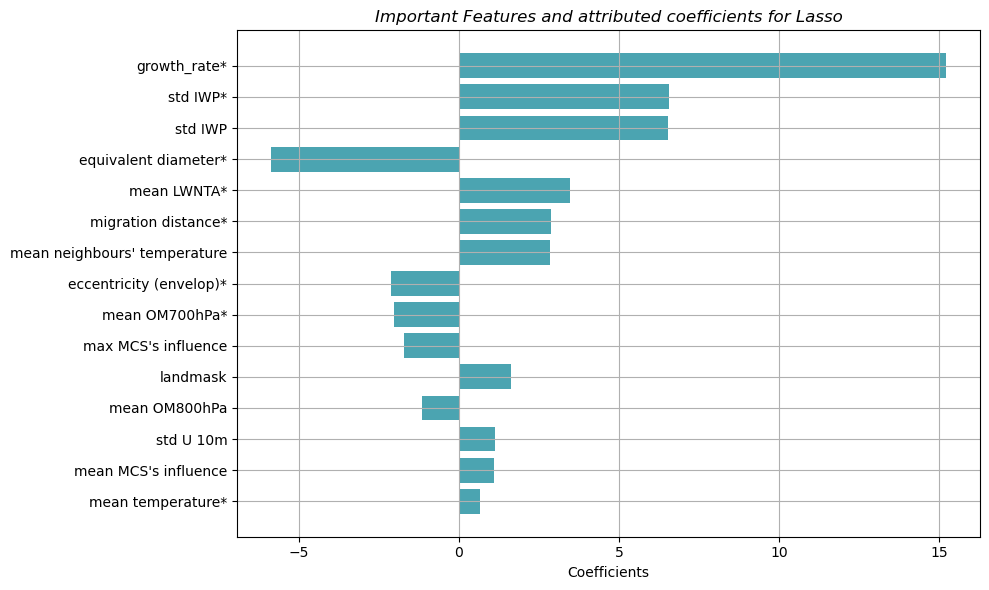

In [18]:
model_str = 'Lasso'
nb_timesteps=3
nb_selected=15
path_model='/work/bb1153/b381993/data/FINAL_VERSION_new/saved_models/'
df_train=df_train
            
plot_features_importance(model_str, nb_selected, path_model, df_train, nb_timesteps)

In [19]:
idx_sys = np.array(['*' in item for item in new_name_features_selected])

In [21]:
sys = np.where(idx_sys)[0]
env = np.where(~idx_sys)[0]
new_name_features_selected = np.array(new_name_features_selected)
print(new_name_features_selected[sys])
print(new_name_features_selected[env])

['growth_rate*' 'std IWP*' 'equivalent diameter*' 'mean LWNTA*'
 'migration distance*' 'eccentricity (envelop)*' 'mean OM700hPa*'
 'mean temperature*']
['std IWP' "mean neighbours' temperature" "max MCS's influence" 'landmask'
 'mean OM800hPa' 'std U 10m' "mean MCS's influence"]


In [24]:
df_train_cut = df_train[features_selected_names_lasso[:15]]


In [25]:
df_train_cut

,gradient_area_time_2,std_under_cloud_var_6_time_2,std_everywhere_var_6_time_2,average_diameter_time_2,mean_under_cloud_var_1_time_1,migration_dist_time_2,mean_under_all_mcs_neighbours_var_5_time_2,eccentricity_172_time_2,mean_under_cloud_var_11_time_2,max_interaction_power_time_2,mean_everywhere_var_9_time_1,mean_under_cloud_var_12_time_2,std_everywhere_var_7_time_2,mean_interaction_power_time_0,mean_under_cloud_var_5_time_0
0,115.0,0.022077,0.172214,5.527906,0.461867,19.114367,27.155720,0.35,0.000983,8.954570e-01,0.001465,-0.003403,2.140870,1.020749e-04,0.809040
1,177.0,0.055937,0.713382,7.611334,0.594705,11.110000,183.386080,0.91,-0.001786,7.069973e-01,0.000061,-0.009292,2.696628,3.277434e-04,0.385614
2,187.0,0.052621,0.681501,5.781223,0.194207,26.664000,90.853630,0.59,-0.007362,9.098077e-01,0.999970,-0.005577,2.372227,8.621893e-07,0.091203
3,157.0,0.141845,0.447002,8.920621,1.230267,27.974265,14.932513,0.80,-0.011280,4.836550e-08,0.998872,-0.000979,1.269201,4.042432e-08,2.222881
4,188.0,0.010160,0.191725,4.950744,0.296163,15.554000,76.362045,0.53,0.003540,5.370227e-01,0.993561,0.002266,1.412120,1.530944e-04,0.452706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51679,114.0,0.187765,0.498020,6.076508,0.448087,5.982918,28.502586,0.49,-0.035864,1.157571e-01,0.000000,-0.015567,1.778537,-4.476751e-12,0.200172
51680,213.0,0.041491,0.414218,5.262410,0.054469,29.645178,46.962860,0.36,-0.000645,5.710132e-01,0.378003,-0.001977,3.067915,0.000000e+00,0.000000
51681,58.0,0.006184,0.063421,6.603670,0.993169,36.171539,39.721096,0.41,0.003172,6.986690e-01,0.000000,-0.000084,2.172149,1.062410e-04,1.130783
51682,282.0,0.006743,0.446314,8.794845,0.555276,35.897509,120.175545,0.43,0.001635,7.511459e-01,0.000000,0.001318,1.852320,2.652971e-04,0.679107


In [49]:
nb_timesteps=3


scaler = StandardScaler().fit(df_train_cut.values)
X_train = scaler.transform(df_train_cut.values)
y_train = df_train['y_max_extend']


In [50]:
df_test_cut = df_test[features_selected_names_lasso[:15]]

nb_timesteps=3
scaler = StandardScaler().fit(df_test_cut.values)
X_test = scaler.transform(df_test_cut.values)


In [51]:

coef_i =values_features_lasso[:15]

aa=0
for idx_sys in sys:
    aa+=coef_i[idx_sys]*X_train[:,idx_sys]
    
bb=0
for idx_env in env:
    bb+=coef_i[idx_env]*X_train[:,idx_env]

(-40.0, 50.0)

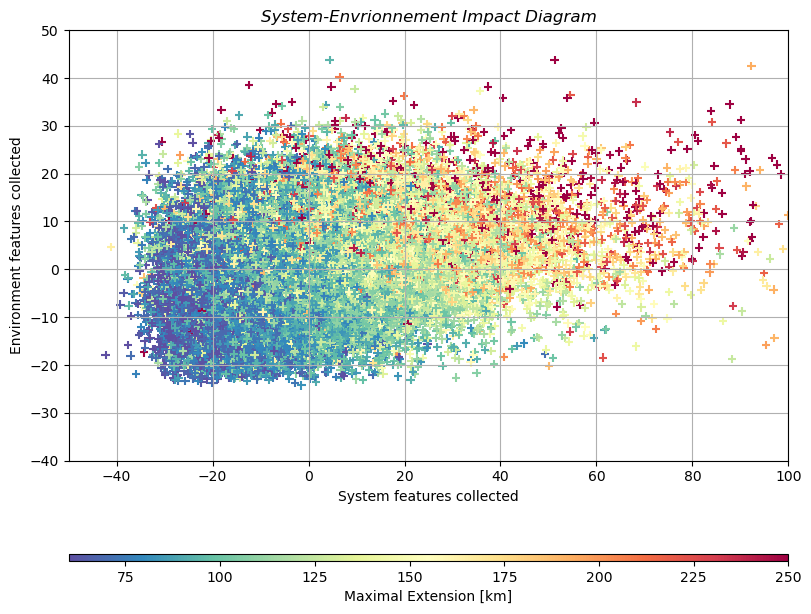

In [87]:
plt.figure(figsize=(8,6), constrained_layout=True)
cmap=plt.get_cmap('Spectral_r')



#color= (aa+bb)+np.mean(df_train['y_max_extend'].values)

color=y_train

im = plt.scatter(aa, bb, c = color, cmap=cmap, marker='+')


plt.clim(60, 250)

plt.title('System-Envrionnement Impact Diagram', fontstyle='italic')
plt.xlabel('System features collected')
plt.ylabel('Environment features collected')
plt.colorbar(im, orientation='horizontal', label='Maximal Extension [km]', aspect=110, pad=0.1)
#plt.legend()
#plt.plot(y_test, 1.13*y_test-13.78967328)
plt.grid(True)

plt.xlim(-50,100)
plt.ylim(-40,50)
#path_fig = os.path.join(path_figures, 'diagram_sys_env.pdf')
#plt.savefig('linear_model.pdf')



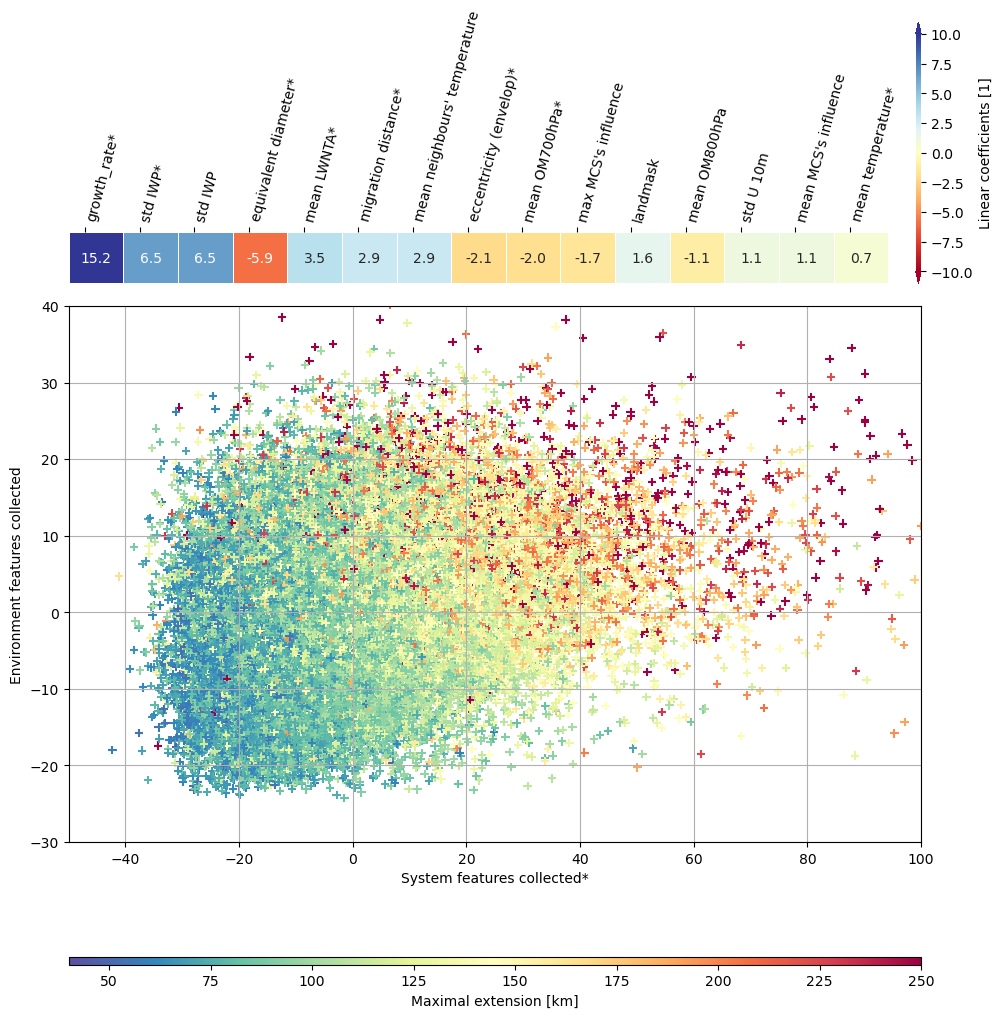

In [121]:
import seaborn as sns
import cmocean
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(11,15))
gs = GridSpec(110, 130, figure=fig)
ax1 = fig.add_subplot(gs[30:35, :125])
ax2 = fig.add_subplot(gs[10:35, 129:])
ax3 = fig.add_subplot(gs[37:110, :])






data = np.array([values_features_lasso[:15]])

sns.heatmap(data,annot=True, cmap='RdYlBu', vmin=-10, vmax=10, fmt=".1f", linewidth=.5, cbar_ax=ax2, ax=ax1, cbar_kws={'label': 'Linear coefficients [1]', 'aspect':'110', 'orientation':'vertical', 'shrink':'0.6',  'extend':'both'}
        )



ax1.xaxis.tick_top()
ax1.set_xticks(np.arange(data.shape[1]) + 0.3, new_name_features_selected[:15], rotation=75, ha='left')


ax1.get_yaxis().set_visible(False)



cmap=plt.get_cmap('YlGnBu',10)


color=y_train
cmap=plt.get_cmap('Spectral_r')

im = ax3.scatter(aa, bb, c = color, cmap=cmap, marker='+')
im.set_clim(40, 250)



ax3.set_xlim(-50,100)
ax3.set_ylim(-30,40)

ax3.set_xlabel('System features collected*')
ax3.set_ylabel('Environment features collected')
fig.colorbar(im, orientation='horizontal', label='Maximal extension [km]', aspect=110, pad=0.15, ax=ax3,)
plt.grid(True)



In [43]:

coef_i =values_features_lasso[:15]

aa=0
for idx_sys in sys:
    aa+=coef_i[idx_sys]*X_test[:,idx_sys]
    
bb=0
for idx_env in env:
    bb+=coef_i[idx_env]*X_test[:,idx_env]

(-30.0, 40.0)

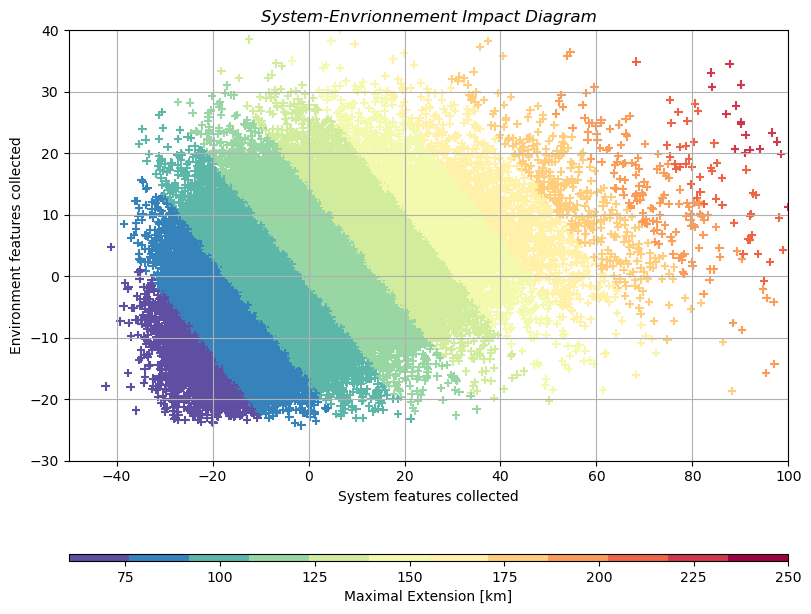

In [53]:
plt.figure(figsize=(8,6), constrained_layout=True)
#cmap=plt.get_cmap('Spectral_r')
cmap=plt.get_cmap('Spectral_r',12)


color= (aa+bb)+np.mean(df_train['y_max_extend'].values)

#color= y_train

im = plt.scatter(aa, bb, c = color, cmap=cmap, marker='+')


plt.clim(60, 250)

plt.title('System-Envrionnement Impact Diagram', fontstyle='italic')
plt.xlabel('System features collected')
plt.ylabel('Environment features collected')
plt.colorbar(im, orientation='horizontal', label='Maximal Extension [km]', aspect=110, pad=0.1)
#plt.legend()
#plt.plot(y_test, 1.13*y_test-13.78967328)
plt.grid(True)

plt.xlim(-50,100)
plt.ylim(-30,40)
#path_fig = os.path.join(path_figures, 'diagram_sys_env.pdf')
#plt.savefig('linear_model.pdf')



Text(0.5, 1.0, 'Correlation between selected features')

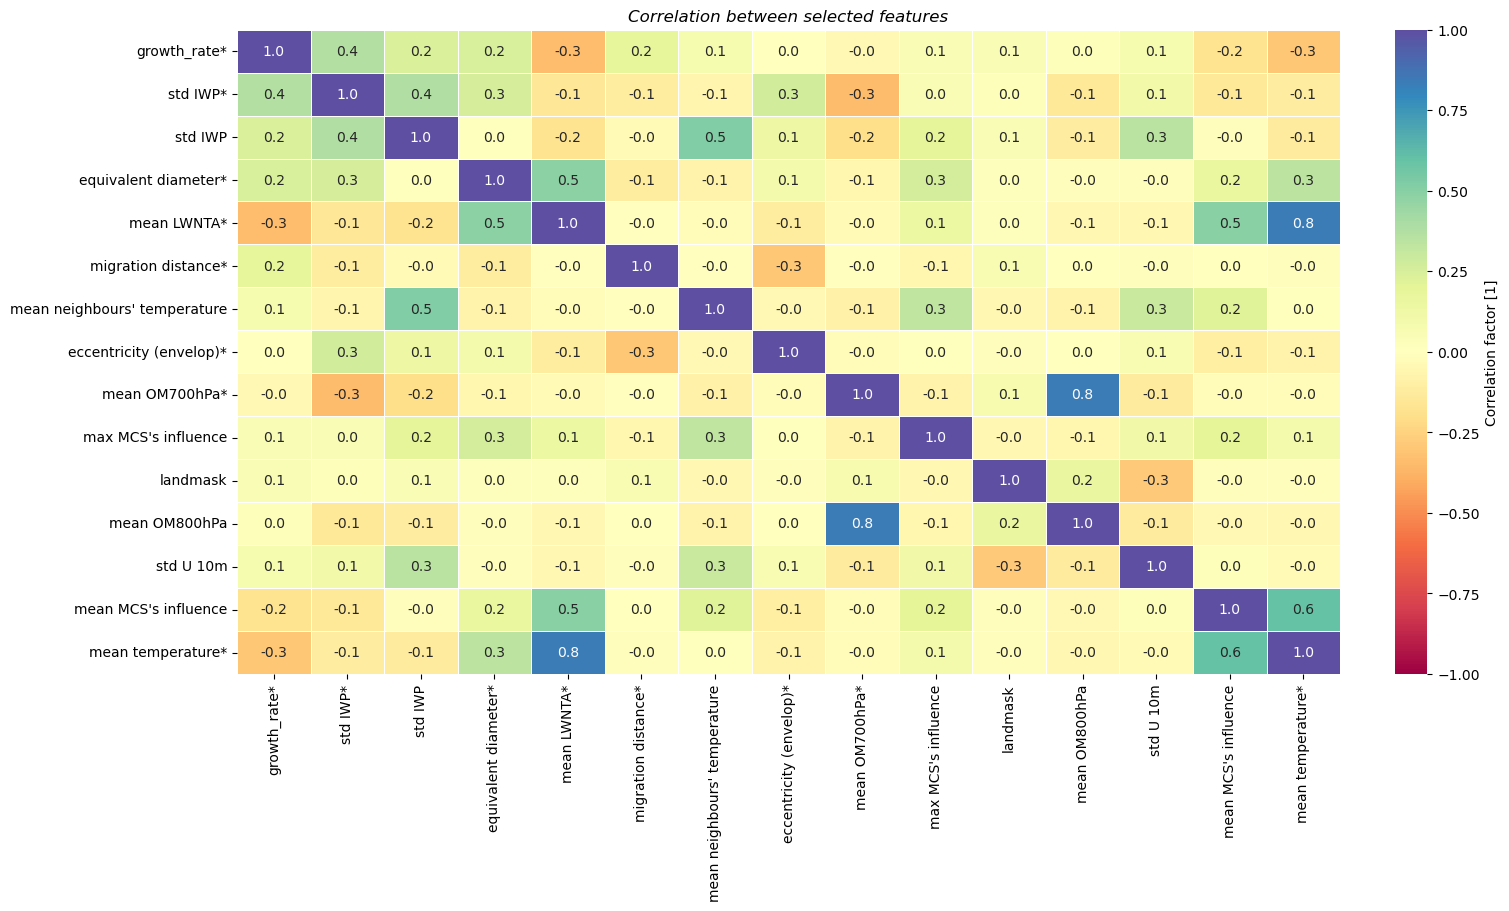

In [58]:
fig = plt.figure(figsize=(15,9), constrained_layout=True)



df = pd.DataFrame(data=X_train)
import seaborn as sns

sns.heatmap(df.corr(),annot=True, cmap='Spectral', vmin=-1, vmax=1, fmt=".1f", linewidth=.5, cbar_kws={'label': 'Correlation factor [1]'})


plt.xticks(np.linspace(0.5,14.5, 15), new_name_features_selected[:15], rotation=90)
plt.yticks(np.linspace(0.5,14.5, 15), new_name_features_selected[:15], rotation=0)

plt.title('Correlation between selected features', fontstyle='italic')

#path_fig = os.path.join(path_figures, 'correl_features_matrx.pdf')
#plt.savefig(path_fig)




In [122]:
idx_small = np.where(df_train['y_max_extend'].values<100)[0]
idx_big = np.where(df_train['y_max_extend'].values>=100)[0]

In [123]:
X_train_small = X_train[idx_small, :]
X_train_big = X_train[idx_big, :]

In [124]:

coef_i =values_features_lasso[:15]

sum_sys_small=0
for idx_sys in sys:
    sum_sys_small+=coef_i[idx_sys]*X_train_small[:,idx_sys]
    
sum_env_small=0
for idx_env in env:
    sum_env_small+=coef_i[idx_env]*X_train_small[:,idx_env]

In [125]:

coef_i =values_features_lasso[:15]

sum_sys_big=0
for idx_sys in sys:
    sum_sys_big+=coef_i[idx_sys]*X_train_big[:,idx_sys]
    
sum_env_big=0
for idx_env in env:
    sum_env_big+=coef_i[idx_env]*X_train_big[:,idx_env]

In [130]:

coef_i =values_features_lasso[:15]

sum_sys_all=0
for idx_sys in sys:
    sum_sys_all+=coef_i[idx_sys]*X_train[:,idx_sys]
    
sum_env_all=0
for idx_env in env:
    sum_env_all+=coef_i[idx_env]*X_train[:,idx_env]

In [126]:
X = np.stack((sum_sys_small, sum_env_small), axis=0)
co_var = np.cov(X)[0,1]
var_sys, var_env, double_co_var = np.var(sum_sys_small), np.var(sum_env_small), 2*co_var

([<matplotlib.patches.Wedge at 0x7fff371d75e0>,
 [Text(-0.8194875840900293, -0.7337847773852271, 'System'),
  Text(1.0293545004568714, 0.3878521785283473, 'Environment'),
  Text(0.3977132172578916, 1.0255848072287232, 'Both')],
 [Text(-0.4469932276854705, -0.4002462422101238, '73.2%'),
  Text(0.5614660911582934, 0.21155573374273487, '15.0%'),
  Text(0.21693448214066813, 0.5594098948520307, '11.8%')])

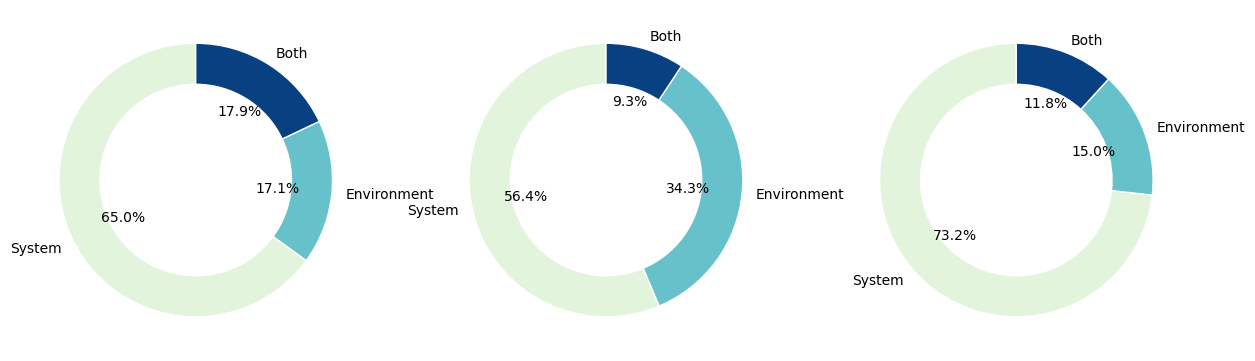

In [133]:

fig, ax = plt.subplots(1,3, figsize=(15,5))
colors = [plt.get_cmap('GnBu',10)(1), plt.get_cmap('GnBu',10)(5), plt.get_cmap('GnBu',10)(9)]

X = np.stack((sum_sys_all, sum_env_all), axis=0)
co_var = np.cov(X)[0,1]
var_sys, var_env, double_co_var = np.var(sum_sys_all), np.var(sum_env_all), 2*co_var

labels = ['System', 'Environment', 'Both']
sizes = [var_sys, var_env, double_co_var]  # percentages or values

size = 0.3
# Create a pie chart
ax[0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors,
       wedgeprops=dict(width=size, edgecolor='w'))

########
X = np.stack((sum_sys_small, sum_env_small), axis=0)
co_var = np.cov(X)[0,1]
var_sys, var_env, double_co_var = np.var(sum_sys_small), np.var(sum_env_small), 2*co_var

labels = ['System', 'Environment', 'Both']
sizes = [var_sys, var_env, double_co_var]  # percentages or values

size = 0.3
ax[1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors,
       wedgeprops=dict(width=size, edgecolor='w'))

###########
X = np.stack((sum_sys_big, sum_env_big), axis=0)
co_var = np.cov(X)[0,1]
var_sys, var_env, double_co_var = np.var(sum_sys_big), np.var(sum_env_big), 2*co_var

labels = ['System', 'Environment', 'Both']
sizes = [var_sys, var_env, double_co_var]  # percentages or values

# Create a pie chart
ax[2].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors,
       wedgeprops=dict(width=size, edgecolor='w'))

